In [3]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# obtain mnist data and process
batch_size = 128
num_of_classes = 10

def get_indices(dataset,ind_array):
    indices =  []
    for i in range(len(dataset.targets)):
        for ind in ind_array:
            if dataset.targets[i] == ind:
                indices.append(i)
    return indices

dataset = MNIST('.', train=True, download=False,transform=transforms.ToTensor())

idx = get_indices(dataset, np.arange(num_of_classes))
data_loader_target = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_gan = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))

classes = np.arange(num_of_classes)

In [5]:
# target model
from net_conv import target_net

net = target_net(num_of_classes)
criterion_tar = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

PATH = './target_models/basic_net_convolutional_'+str(num_of_classes)+'classes.pth'
# train and and save the model
#net.train(data_loader_target, criterion_tar, optimizer)
#torch.save(net.state_dict(), PATH)
# load the model
net = target_net(num_of_classes)
net.load_state_dict(torch.load(PATH))

print('model accuracy: ', net.accuracy(data_loader_gan))

model accuracy:  98.41833333333334


In [18]:
from advGAN import advGAN

class NET():
    def __init__(self,net):
        self.net = net
    
    def pred(self,x):
        return self.net(x.reshape(len(x),1,28,28))

advgan = advGAN(NET(net).pred,disc_coeff=9.,hinge_coeff=11.,adv_coeff=5.,c=0.2,gen_path_extra='NNgan_onConvNet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  1
Step 500: Generator loss: 156.4961116180422, discriminator loss: 2.939825472116473
% wrong: 0.6640625 | target model % correct: 0.9921875


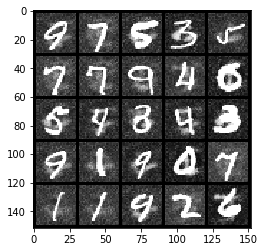

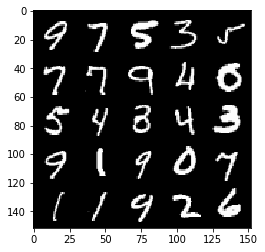

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  2
Step 1000: Generator loss: 85.17612388610841, discriminator loss: 0.4836290917396543
% wrong: 0.640625 | target model % correct: 0.9765625


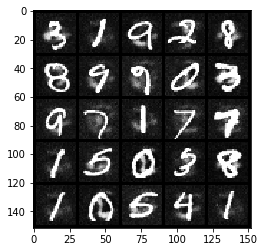

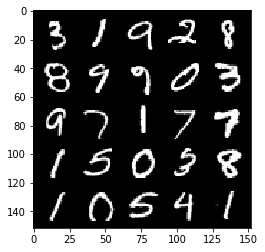

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  3
Step 1500: Generator loss: 65.24151202392576, discriminator loss: 0.4150247178077693
% wrong: 0.640625 | target model % correct: 0.984375


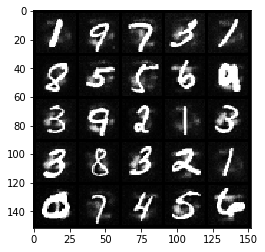

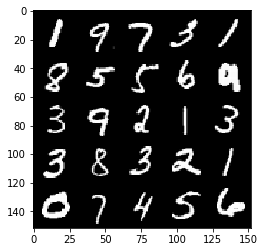

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  4
Step 2000: Generator loss: 57.77133769989017, discriminator loss: 0.466937267839909
% wrong: 0.578125 | target model % correct: 0.96875


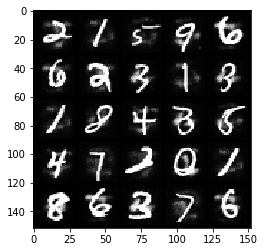

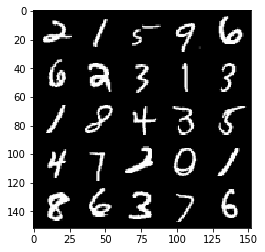

KeyboardInterrupt: 

In [19]:
# train the gen/disc
gen,disc = advgan.train(data_loader_gan)

In [ ]:
# load the generator 
gen = advgan.load_gen()

In [ ]:
from sklearn.metrics import accuracy_score

def one_batch(data,num=1):
    for i,(img,lbl) in enumerate(data):
        if i == num:
            return img,lbl
            break

images,labels = one_batch(data_loader_test,num=1)
perts = gen(images.reshape(len(images),28*28))
adv_images = images.reshape(len(images),28*28) + perts
net_out = net(images.reshape(len(images),28*28))
adv_pred = net(adv_images)

print('% wrong: ',1.-accuracy_score(labels,torch.argmax(adv_pred,dim=1)))
print('-----------------------------------------')
for img,lbl,adimg,out,adpred,p in zip(images,labels,adv_images,net_out,adv_pred,perts):
    print('target model output: ', int(torch.argmax(out).detach()))
    print('target model output on adv example: ', int(torch.argmax(adpred).detach()))
    print('frobenius norm of pertubation: ',float(torch.norm(p,'fro').detach()))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('actual label: '+str(int(lbl.detach())))
    ax1.imshow(img.reshape(28,28).detach().numpy(),cmap='gray')
    ax2.imshow(adimg.reshape(28,28).detach().numpy(),cmap='gray')
    plt.show()
